In [6]:
import pandas as pd

df = pd.read_csv("PBL5recommendationdata.csv", encoding='latin-1', low_memory=False)
df.head()

,Customers.id,Customers.fname,Customers.lname,Customers.company,Customers.create_date,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,...,Products.google_shopping_label,Products.product_option,Products.size,Products.material,Products.arm_style,Products.leg_style,Products.seat_size,Products.family_id,Products.saved_status,Products.freight_cost
0,797,Christy,Dill,Company0,1426018724,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF61071,0.0,NaN
1,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF02132,NaN,NaN
2,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2 x Extra large,Nitrile,NaN,NaN,NaN,PF00342,0.0,NaN
3,4,James,Anderson,NaN,1386780263,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF04970,NaN,NaN
4,5,Abraham,Pollak,Company3,1386861599,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF03045,NaN,NaN


In [10]:
customer_df = df[[
    'Customers.id',
    'Customers.fname',
    'Customers.lname',
    'Customers.company',
    'Customers.status',
    'Customers.customer_type',
    'Customers.create_date'
]].drop_duplicates()

In [12]:
product_df = df[[
    'Products.id',
    'Products.name',
    'Products.product_type',
    'Products.vendor',
    'Products.list_price',
    'Products.price',
    'Products.cost'
]].drop_duplicates()

In [14]:
orders_df = df[[
    'Orders.id',
    'Orders.customer_id',
    'Order_Items.product_id',
    'Order_Items.product_name',
    'Order_Items.qty',
    'Order_Items.price',
    'Orders.placed_date'
]].drop_duplicates()

In [16]:
import sqlite3

conn = sqlite3.connect("customer_segmentation.db")

customer_df.to_sql("Customer", conn, index=False, if_exists="replace")
product_df.to_sql("Products", conn, index=False, if_exists="replace")
orders_df.to_sql("Orders", conn, index=False, if_exists="replace")

conn.commit()
conn.close()

In [18]:
import sqlite3

conn = sqlite3.connect("customer_segmentation.db")

query = """
SELECT 
    o."Orders.id" AS OrderID,
    o."Orders.customer_id" AS CustomerID,
    c."Customers.fname" AS FirstName,
    c."Customers.lname" AS LastName,
    c."Customers.company" AS Company,
    c."Customers.status" AS Status,
    c."Customers.customer_type" AS CustomerType,
    o."Orders.placed_date" AS OrderDate,
    o."Order_Items.product_id" AS ProductID,
    o."Order_Items.product_name" AS ProductName,
    o."Order_Items.qty" AS Quantity,
    o."Order_Items.price" AS Price,
    p."Products.product_type" AS ProductType,
    p."Products.vendor" AS Vendor
FROM Orders o
JOIN Customer c ON o."Orders.customer_id" = c."Customers.id"
LEFT JOIN Products p ON o."Order_Items.product_id" = p."Products.id"
"""

merged_df = pd.read_sql_query(query, conn)
conn.close()

merged_df['OrderDate'] = pd.to_datetime(merged_df['OrderDate'])

merged_df.head()

,OrderID,CustomerID,FirstName,LastName,Company,Status,CustomerType,OrderDate,ProductID,ProductName,Quantity,Price,ProductType,Vendor
0,3758,797,Christy,Dill,Company0,NaN,0.0,1970-01-01 00:00:01.426019099,2310.0,"Basic Rollators, Green",1,57.20,None,1.0
1,23,3,John,Smith,Company1,NaN,0.0,1970-01-01 00:00:01.386090455,177.0,"Urinary Drain Bags,0.000",4,5.00,None,1.0
2,9531,3,John,Smith,Company1,NaN,0.0,1970-01-01 00:00:01.449603652,1.0,"SensiCare Nitrile Exam Gloves, Blue, XX-Large",1,68.78,None,1.0
3,29,4,James,Anderson,None,NaN,0.0,1970-01-01 00:00:01.386780263,983.0,Basket for 2-Button Walkers,1,19.56,None,1.0
4,30,5,Abraham,Pollak,Company3,0.0,0.0,1970-01-01 00:00:01.386861599,991.0,Tens Units,1,36.05,None,1.0


In [20]:
segment_df = merged_df.groupby('CustomerID').agg({
    'OrderID': 'nunique',           
    'Price': 'sum'                  
}).reset_index()

segment_df.columns = ['CustomerID', 'TotalOrders', 'TotalSpent']
segment_df.head()

,CustomerID,TotalOrders,TotalSpent
0,3,2,73.78
1,4,1,19.56
2,5,3,95.14
3,7,1,39.19
4,8,1,59.75


In [22]:
from sklearn.preprocessing import StandardScaler

X = segment_df[['TotalOrders', 'TotalSpent']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

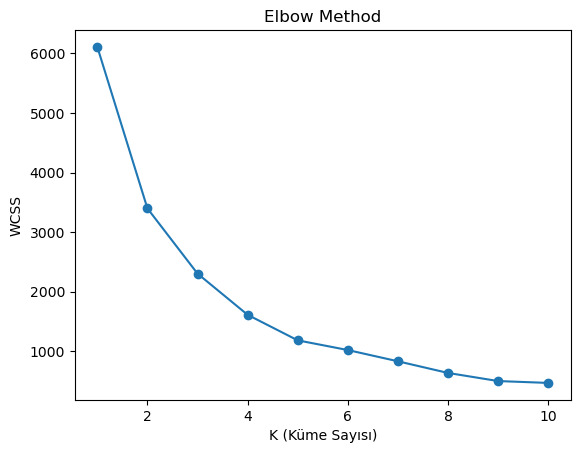

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("K (Küme Sayısı)")
plt.ylabel("WCSS")
plt.show()

In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)
segment_df['Cluster'] = kmeans.fit_predict(X_scaled)
segment_df.head()

,CustomerID,TotalOrders,TotalSpent,Cluster
0,3,2,73.78,1
1,4,1,19.56,1
2,5,3,95.14,1
3,7,1,39.19,1
4,8,1,59.75,1


In [28]:
segment_df.groupby('Cluster').agg({
    'TotalOrders': 'mean',
    'TotalSpent': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'})

,TotalOrders,TotalSpent,CustomerCount
Cluster,,,
0,4.800000,271.264833,60
1,1.053668,73.614752,2944
2,13.444444,1406.367778,9
3,1.317073,897.737317,41


In [30]:
import datetime as dt

reference_date = merged_df['OrderDate'].max() + pd.Timedelta(days=1)

In [32]:
rfm = merged_df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (reference_date - x.max()).days,  
    'OrderID': 'nunique',                                    
    'Price': 'sum'                                           
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,3,1,2,73.78
1,4,1,1,19.56
2,5,1,3,95.14
3,7,1,1,39.19
4,8,1,1,59.75


In [40]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=False, duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), q=5, labels=False, duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=False, duplicates='drop')

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [44]:
rfm.groupby('RFM_Score').agg({
    'CustomerID': 'count',
    'Monetary': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean'
}).sort_values(by='CustomerID', ascending=False).head(10)

,CustomerID,Monetary,Frequency,Recency
RFM_Score,,,,
nan30,172,15.293837,1.000000,1.0
nan44,171,345.071111,3.263158,1.0
nan03,158,103.399177,1.000000,1.0
nan20,141,14.789645,1.000000,1.0
nan01,136,31.012647,1.000000,1.0
nan13,136,97.481691,1.000000,1.0
nan14,133,193.100827,1.000000,1.0
nan31,132,31.872652,1.000000,1.0
nan11,128,32.610312,1.000000,1.0


In [46]:
rfm['RFM_Score'].value_counts().head(10)

RFM_Score
nan30    172
nan44    171
nan03    158
nan20    141
nan13    136
nan01    136
nan14    133
nan31    132
nan12    128
nan11    128
Name: count, dtype: int64

In [48]:
def segment_rfm(row):
    if row['R_Score'] <= 1 and row['F_Score'] <= 1:
        return 'Hibernating'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Champions'
    elif row['R_Score'] >= 2 and row['F_Score'] >= 2:
        return 'Loyal'
    elif row['R_Score'] >= 3 and row['F_Score'] <= 1:
        return 'New Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_rfm, axis=1)

In [50]:
rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'CustomerID': 'Müşteri Sayısı'})

,Müşteri Sayısı,Recency,Frequency,Monetary
Segment,,,,
Others,3054,1.0,1.167322,92.48928
